In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf
import pandas as pd

# Import src code
from src.model.build_unet import *
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.overfitting_test import *
from src.data.create_dataset import dataset_tf
from src.data.path_loader import PathLoader

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 32
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 32
EPOCHS = 100
T = int(config_hp["T"])  # number of diffusion steps
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

In [4]:
# Load csv data
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

# Show the df
df

,name,pokedex_id,type1,image_fn
0,Bulbasaur,1,Grass,['1']
1,Ivysaur,2,Grass,['2']
2,Venusaur,3,Grass,['3']
3,Venusaur Gmax,3,Grass,['3_g']
4,Venusaur Mega,3,Grass,['3_2']
...,...,...,...,...
1113,Glastrier,896,Ice,['896']
1114,Spectrier,897,Ghost,['897']
1115,Calyrex,898,Psychic,['898_1']
1116,Calyrex Ice Rider,898,Psychic,['898_2']


- The shape of the dataset is: (32, 32, 32, 3) => batch_size: 32, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


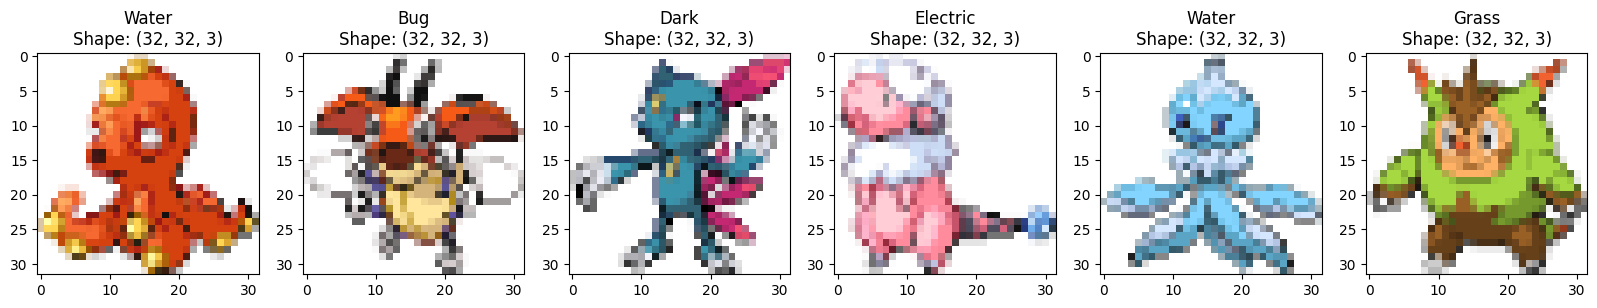

In [5]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    image_paths=PathLoader.get_image_paths(f"{DATA_PATH}/interim/image_paths.json"),
    df=df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    save=False,
    save_path=dataset_path,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [6]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

In [7]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

Epoch 1/100


I0000 00:00:1715116169.042275   71235 service.cc:145] XLA service 0x7d6298005470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715116169.042297   71235 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1715116169.591813   71235 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1715116170.653459   71345 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3260', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1715116171.095279   71342 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_7015', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1715116171.216629   71347 asm_compiler.cc:369] ptxas warning

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/pqlza/.local/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/pqlza/.local/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/pqlza/.local/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/pqlza/.local/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/pqlza/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/pqlza/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/pqlza/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/pqlza/.local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/pqlza/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/pqlza/.local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/pqlza/.local/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/pqlza/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/pqlza/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/pqlza/.local/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/pqlza/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/pqlza/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/pqlza/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_71121/4058675635.py", line 2, in <module>

  File "/home/pqlza/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/pqlza/.local/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 325, in fit

  File "/home/pqlza/.local/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 118, in one_step_on_iterator

Out of memory while trying to allocate 561187768 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  920.49MiB
              constant allocation:    11.9KiB
        maybe_live_out allocation:  920.11MiB
     preallocated temp allocation:  535.19MiB
  preallocated temp fragmentation:    1.12MiB (0.21%)
                 total allocation:    1.42GiB
              total fragmentation:  165.05MiB (11.34%)
Peak buffers:
	Buffer 1:
		Size: 72.00MiB
		Operator: op_name="XLA_Args"
		XLA Label: fusion
		Shape: f32[2048,1024,3,3]
		==========================

	Buffer 2:
		Size: 72.00MiB
		Operator: op_name="XLA_Args"
		XLA Label: fusion
		Shape: f32[2048,1024,3,3]
		==========================

	Buffer 3:
		Size: 72.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,2048,1024]
		==========================

	Buffer 4:
		Size: 72.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,2048,1024]
		==========================

	Buffer 5:
		Size: 72.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,2048,1024]
		==========================

	Buffer 6:
		Size: 72.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,2048,1024]
		==========================

	Buffer 7:
		Size: 72.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,2048,1024]
		==========================

	Buffer 8:
		Size: 72.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,2048,1024]
		==========================

	Buffer 9:
		Size: 27.00MiB
		Operator: op_name="XLA_Args"
		XLA Label: fusion
		Shape: f32[512,1536,3,3]
		==========================

	Buffer 10:
		Size: 27.00MiB
		Operator: op_name="XLA_Args"
		XLA Label: fusion
		Shape: f32[512,1536,3,3]
		==========================

	Buffer 11:
		Size: 27.00MiB
		Operator: op_name="XLA_Retvals"
		XLA Label: fusion
		Shape: f32[3,3,1536,512]
		==========================

	Buffer 12:
		Size: 27.00MiB
		Operator: op_name="XLA_Retvals"
		XLA Label: fusion
		Shape: f32[3,3,1536,512]
		==========================

	Buffer 13:
		Size: 27.00MiB
		Operator: op_name="XLA_Retvals"
		XLA Label: fusion
		Shape: f32[3,3,1536,512]
		==========================

	Buffer 14:
		Size: 27.00MiB
		Operator: op_name="XLA_Retvals"
		XLA Label: fusion
		Shape: f32[3,3,1536,512]
		==========================

	Buffer 15:
		Size: 27.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,1536,512]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_43977]

In [ ]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

In [ ]:
model.plot_samples(6)

model.plot_samples(3, "Fire")
model.plot_samples(3, "Grass")
model.plot_samples(3, "Water")

In [ ]:
model.plot_samples(6)
model.plot_samples(6)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [ ]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "../../models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.keras"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [ ]:
# Save the model
SCHEDULER = "linear"
EPOCHS = 600
model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{SCHEDULER}_ddpm"

save_model(model, model_name)

In [ ]:
# load the model
# =====================================================================
model_loaded = tf.keras.models.load_model(f"../../models/{model_name}.keras")

model_load.plot_samples(6)

[BACK TO TOP](#top)